# Minimierung der Durschlaufzeit (Flow Time) jedes Produktionsauftrags
- Es liegen Ankunftszeiten 'Arrival' vor, aber es werden speziell die frühsten Bearbeitungszeiten 'Ready Time' verwedendet, um die Kausalität zu bewahren, dass bereits angekommene Aufträge (Jobs) geplant werden können.
- Die 'Ready Time' sind auf den nächsten Tagesbeginn bzw. Schichtbeginn aufgerundete Ankunftszeiten

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.presenter as show
from src.utils.initialization import jobs_jssp_init as init
from src.utils.analize import check_constrains as check
from src.utils.rolling_process.rolling_filter import *

# Solver Model
from src.models.lp import flowtime_scheduling as lp_ft_schedule
from src.models.lp import flowtime_rescheduling as lp_ft_reschedule

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Extern
import pandas as pd

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Harte Abbruchbedingung für die Scheduler
max_time = 60*15     # 15 min

# Simulation
simulation = ProductionSimulation(sigma = 0.25)

In [3]:
# Datei laden
basic_data_path = get_path("data", "basic")
examples_data_path = get_path("data", "examples")
df_routings = pd.read_csv(basic_data_path / "instance.csv")
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
5,0,5,M05,11
...,...,...,...,...
94,9,4,M08,64
95,9,5,M09,76
96,9,6,M05,47


## I. Generierung der Job-Shop Scheduling Problems und der dazugehörigen Produktionsauftragsinformationen

In [4]:
# Generierung auf Basis von den Arbeitsplänen (Routings) und der Vorgabe bestimmten Parameter, insbesondere der Maximalauslastung (95 %)
df_jssp, df_jobs_arrivals = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = 2, shift_length = 1440,
                                                        u_b_mmax = 0.95, shuffle = True
                                                       )
df_jobs_arrivals

,Job,Routing_ID,Arrival,Ready Time
0,J25-0000,8,75,1440
1,J25-0001,6,123,1440
2,J25-0002,0,187,1440
3,J25-0003,2,231,1440
4,J25-0004,3,271,1440
5,J25-0005,1,472,1440
...,...,...,...,...
33,J25-0033,2,2520,2880
34,J25-0034,8,2572,2880
35,J25-0035,5,2583,2880


## Tag 1
- Am Tag 0 kommen die ersten Produktionsaufträge an, somit kann noch nichts geplant werden
- Am Tag 1 findet die initiale Planung statt

In [5]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [6]:
# "neue" und unerledigte Jobs
df_jobs_arrivals_current = get_current_jobs(
    df_jobs_arrivals, df_previous_not_started = None, ready_time=day_start
)
df_jobs_arrivals_current

,Job,Routing_ID,Arrival,Ready Time
0,J25-0000,8,75,1440
1,J25-0001,6,123,1440
2,J25-0002,0,187,1440
3,J25-0003,2,231,1440
4,J25-0004,3,271,1440
5,J25-0005,1,472,1440
...,...,...,...,...
11,J25-0011,1,976,1440
12,J25-0012,2,1045,1440
13,J25-0013,3,1129,1440


In [7]:
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_arrivals_current)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
164,J25-0016,6,4,M06,32
165,J25-0016,6,5,M05,21
166,J25-0016,6,6,M09,32


### Scheduling

In [8]:
# Scheduling
df_schedule = lp_ft_schedule.solve_jssp(
    df_jssp_current, df_jobs_arrivals_current, solver= "HiGHS",
    var_cat="Integer", msg=False, earliest_start_column = "Ready Time",
    timeLimit=max_time, gapRel= 0.05)
df_schedule

BigM: 9000

Solver-Informationen:
  Summe Flow Times        : 17182.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 1547
  Anzahl Constraints      : 2890
  Laufzeit                : ~900.26 Sekunden


,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Start,End
0,J25-0000,8,0,M00,76,75,1440,1565.0,1641.0
1,J25-0000,8,1,M01,69,75,1440,1641.0,1710.0
2,J25-0000,8,2,M03,76,75,1440,1710.0,1786.0
3,J25-0000,8,3,M05,51,75,1440,1786.0,1837.0
4,J25-0000,8,4,M02,85,75,1440,1846.0,1931.0
5,J25-0000,8,5,M09,11,75,1440,1931.0,1942.0
...,...,...,...,...,...,...,...,...,...
164,J25-0016,6,4,M06,32,1421,1440,1655.0,1687.0
165,J25-0016,6,5,M05,21,1421,1440,1687.0,1708.0
166,J25-0016,6,6,M09,32,1421,1440,1708.0,1740.0


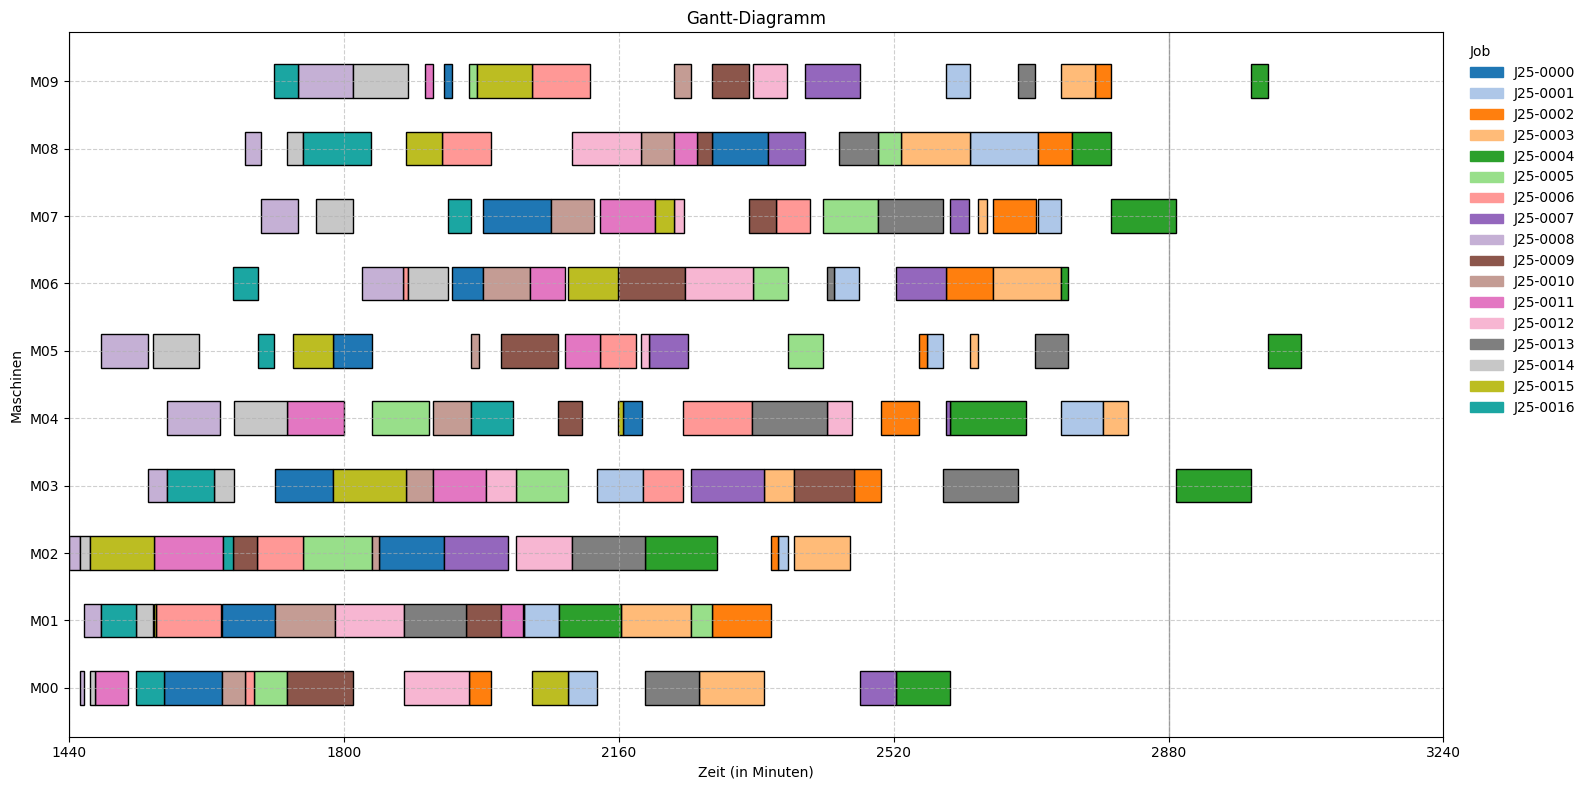

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [9]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

In [10]:
df_schedule.to_csv(examples_data_path / "flowtime_schedule_day_01.csv", index=False)

### Simulation

In [11]:
simulation.run(dframe_schedule_plan= df_schedule, start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0008 started on M02
[Day 1 00:22:00] Job J25-0008 finished on M02 (after 22 minutes)
[Day 1 00:22:00] Job J25-0014 started on M02
[Day 1 00:22:00] Job J25-0008 started on M00
[Day 1 00:29:00] Job J25-0008 finished on M00 (after 07 minutes)
[Day 1 00:29:00] Job J25-0008 started on M01
[Day 1 00:34:00] Job J25-0011 started on M00
[Day 1 00:36:00] Job J25-0014 finished on M02 (after 14 minutes)
[Day 1 00:36:00] Job J25-0015 started on M02
[Day 1 00:54:00] Job J25-0008 finished on M01 (after 25 minutes)
[Day 1 00:54:00] Job J25-0016 started on M01
[Day 1 00:54:00] Job J25-0008 started on M05
[Day 1 01:33:00] Job J25-0011 finished on M00 (after 59 minutes)
[Day 1 01:33:00] Job J25-0014 started on M00
[Day 1 01:40:00] Job J25-0016 finished on M01 (after 46 minutes)
[Day 1 01:41:00] Job J25-0014 finished on M00 (after 08 minutes)
[Day 1 01:41:00] Job J25-0016 started on M00
[Day 1 01:41:00] Job J25-0014 started on M01
[Day 1 01:57:00] Job J25-0008 finished on M05 (aft

In [12]:
df_execution = simulation.get_finished_operations_df()
df_execution

,Job,Routing_ID,Arrival,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,75,0,M00,1573.0,77.0,1650.0
1,J25-0000,8,75,1,M01,1650.0,55.0,1705.0
2,J25-0000,8,75,2,M03,1710.0,86.0,1796.0
3,J25-0000,8,75,3,M05,1796.0,70.0,1866.0
4,J25-0000,8,75,4,M02,1869.0,69.0,1938.0
5,J25-0000,8,75,5,M09,1998.0,9.0,2007.0
...,...,...,...,...,...,...,...,...
152,J25-0016,6,1421,4,M06,1699.0,24.0,1723.0
153,J25-0016,6,1421,5,M05,1723.0,18.0,1741.0
154,J25-0016,6,1421,6,M09,1788.0,68.0,1856.0


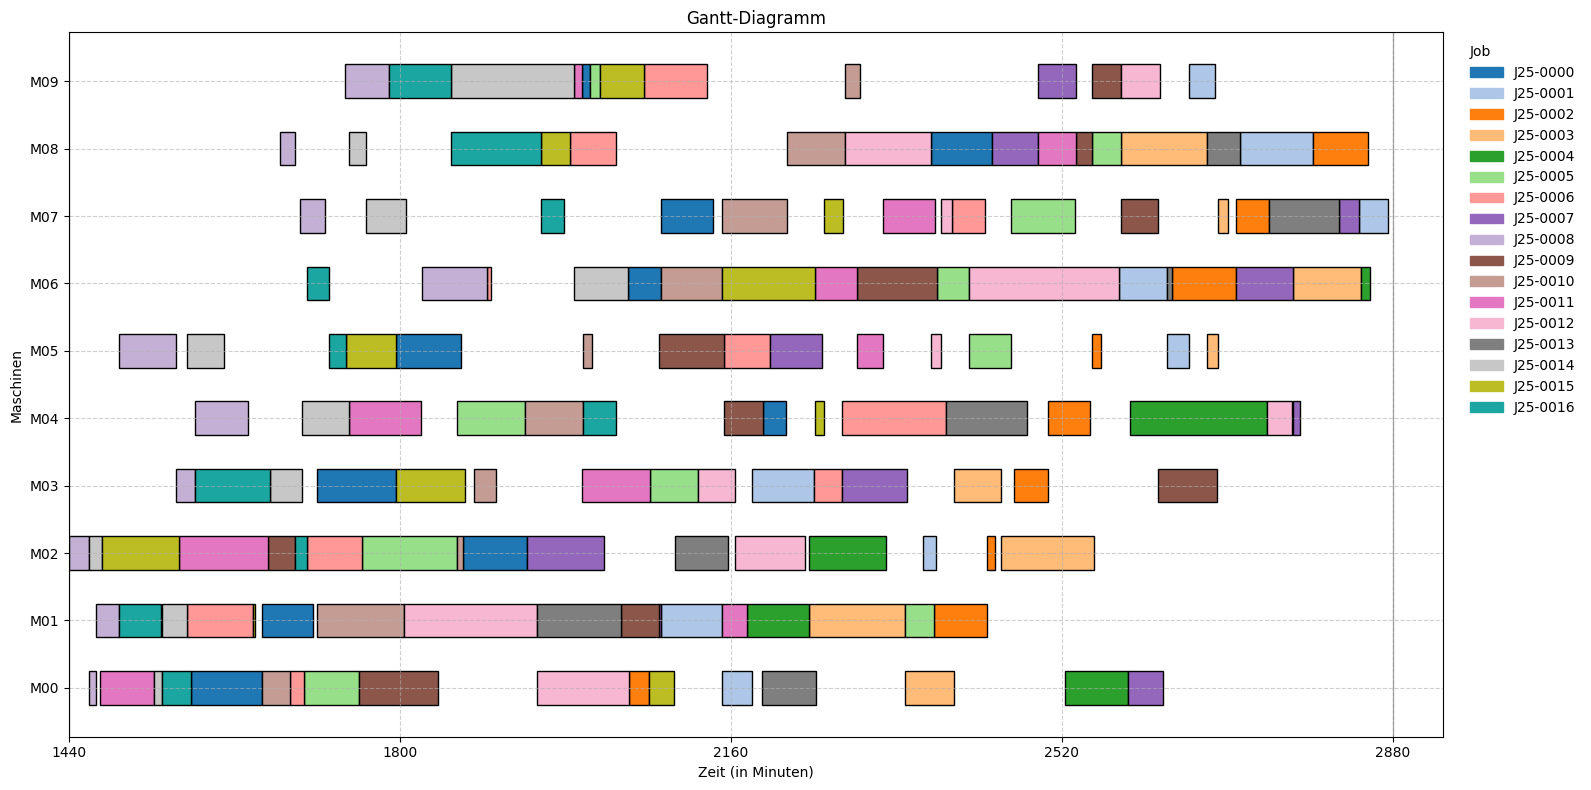

In [13]:
show.plot_gantt(df_execution, perspective="Machine")

In [14]:
df_active = simulation.get_active_operations_df()
df_active

,Routing_ID,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,6,J25-0001,9,M04,123,2875.0,55,40.0,2930.0,2915.0
1,2,J25-0003,8,M09,231,2845.0,45,50.0,2890.0,2895.0
2,3,J25-0004,5,M08,271,2855.0,52,42.0,2907.0,2897.0
3,3,J25-0013,7,M03,1129,2821.0,98,128.0,2919.0,2949.0


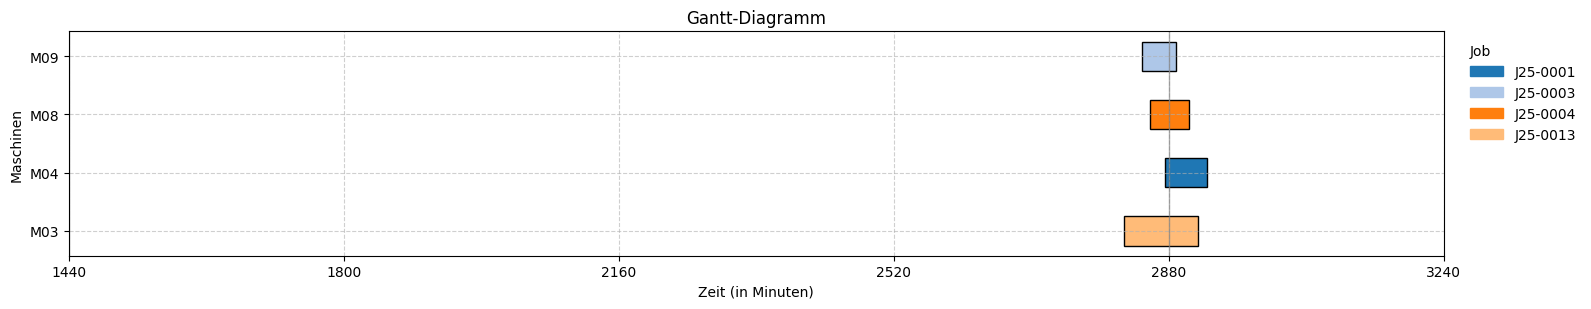

In [15]:
show.plot_gantt(df_active, perspective="Machine", duration_column="Planned Duration")

In [16]:
df_not_started = simulation.get_not_started_operations_df(df_schedule)
df_not_started

,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Start,End
0,J25-0002,0,9,M09,21,187,1440,2784.0,2805.0
1,J25-0003,2,9,M04,33,231,1440,2794.0,2827.0
2,J25-0004,3,6,M07,85,271,1440,2805.0,2890.0
3,J25-0004,3,7,M03,98,271,1440,2890.0,2988.0
4,J25-0004,3,8,M09,22,271,1440,2988.0,3010.0
5,J25-0004,3,9,M05,43,271,1440,3010.0,3053.0
6,J25-0013,3,8,M09,22,1129,1440,2683.0,2705.0
7,J25-0013,3,9,M05,43,1129,1440,2705.0,2748.0


## Tag 2
- hier findet die Neuplanung statt, also das Scheduling mit bestimmter Berücksichtigung der Simulation

In [17]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [18]:
df_not_started["Job"].unique()

array(['J25-0002', 'J25-0003', 'J25-0004', 'J25-0013'], dtype=object)

In [19]:
# "neue" und unerledigte Jobs
df_jobs_arrivals_current = get_current_jobs(df_jobs_arrivals, df_not_started, ready_time=day_start)
df_jobs_arrivals_current

,Job,Routing_ID,Arrival,Ready Time
2,J25-0002,0,187,1440
3,J25-0003,2,231,1440
4,J25-0004,3,271,1440
13,J25-0013,3,1129,1440
17,J25-0017,7,1766,2880
18,J25-0018,8,1818,2880
...,...,...,...,...
33,J25-0033,2,2520,2880
34,J25-0034,8,2572,2880
35,J25-0035,5,2583,2880


In [20]:
df_jssp_current = filter_current_jssp(
    df_jssp = df_jssp,
    df_jobs_times_current = df_jobs_arrivals_current,
    exclusion_dataframes_list = [df_active, df_execution]
)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
29,J25-0002,0,9,M09,21
39,J25-0003,2,9,M04,33
46,J25-0004,3,6,M07,85
47,J25-0004,3,7,M03,98
48,J25-0004,3,8,M09,22
49,J25-0004,3,9,M05,43
...,...,...,...,...,...
384,J25-0038,3,4,M06,9
385,J25-0038,3,5,M08,52
386,J25-0038,3,6,M07,85


### a) einfache Neuplanung
- berücksichtigt lediglich die aktiven Arbeitsgänge (Operationen)

In [21]:
df_schedule_simple = lp_ft_reschedule.solve_jssp_with_fixed_ops(df_jssp_current, df_jobs_arrivals_current,
                                                           df_active, reschedule_start = day_start,
                                                           solver= "HiGHS", msg=False,
                                                           timeLimit=max_time, gapRel= 0.10)
df_schedule_simple

BigM: 15000

Solver-Informationen:
  Summe Flow Times        : 55635.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 2837
  Anzahl Constraints      : 5420
  Laufzeit                : ~900.39 Sekunden


,Job,Routing_ID,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,J25-0002,0,9,187,M09,2895.0,21.0,2729.0,2916.0
1,J25-0003,2,9,231,M04,2915.0,33.0,2717.0,2948.0
2,J25-0004,3,6,271,M07,2897.0,85.0,2711.0,2982.0
3,J25-0004,3,7,271,M03,3024.0,98.0,2851.0,3122.0
4,J25-0004,3,8,271,M09,3122.0,22.0,2873.0,3144.0
5,J25-0004,3,9,271,M05,3144.0,43.0,2916.0,3187.0
...,...,...,...,...,...,...,...,...,...
222,J25-0038,3,4,2815,M06,4541.0,9.0,1735.0,4550.0
223,J25-0038,3,5,2815,M08,4698.0,52.0,1935.0,4750.0
224,J25-0038,3,6,2815,M07,4750.0,85.0,2020.0,4835.0


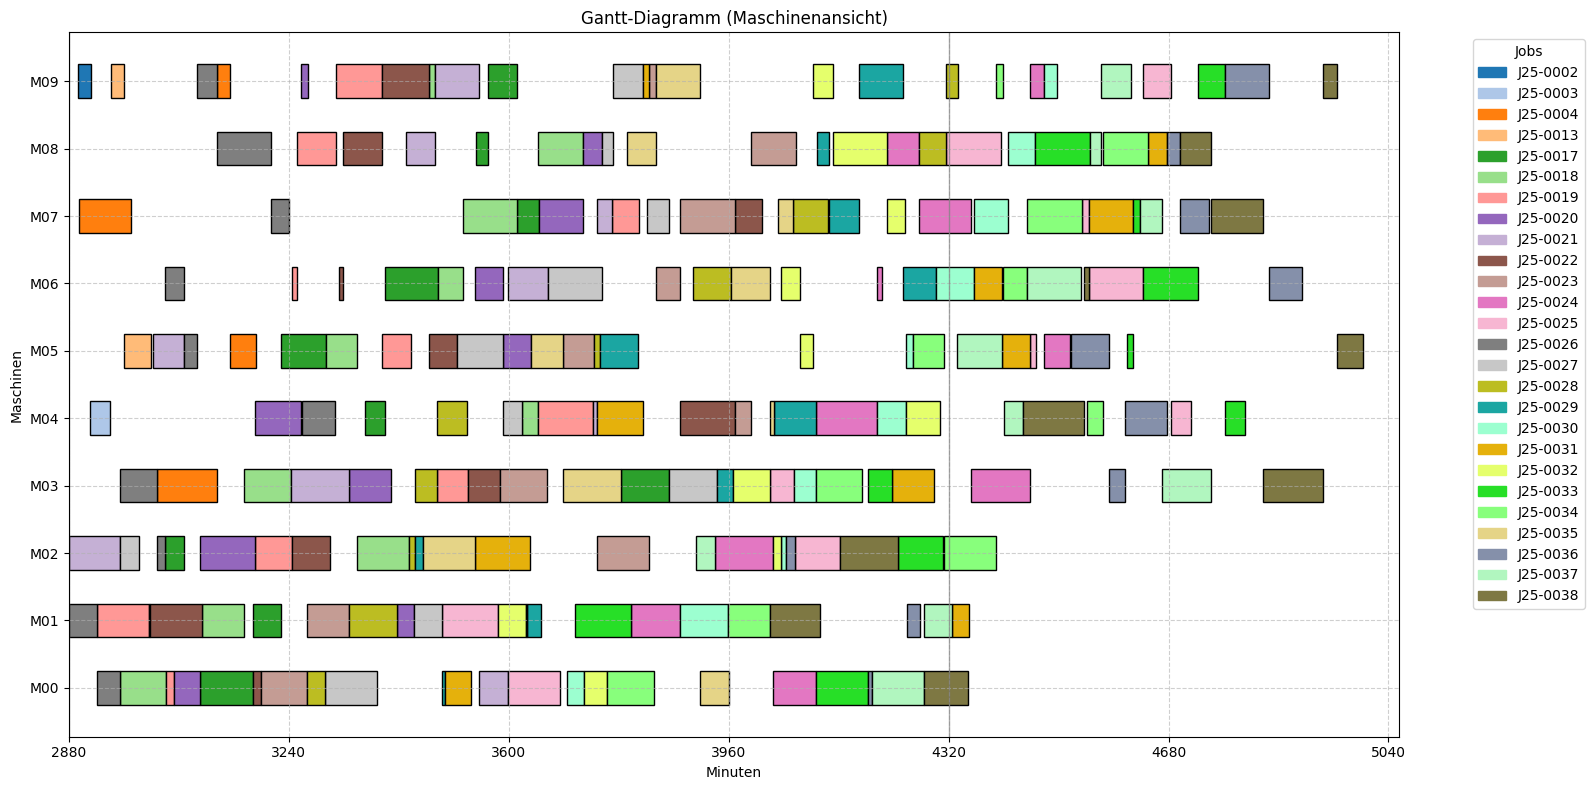

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [22]:
df_temp =  df_schedule_simple

show.plot_gantt_machines(df_temp)
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

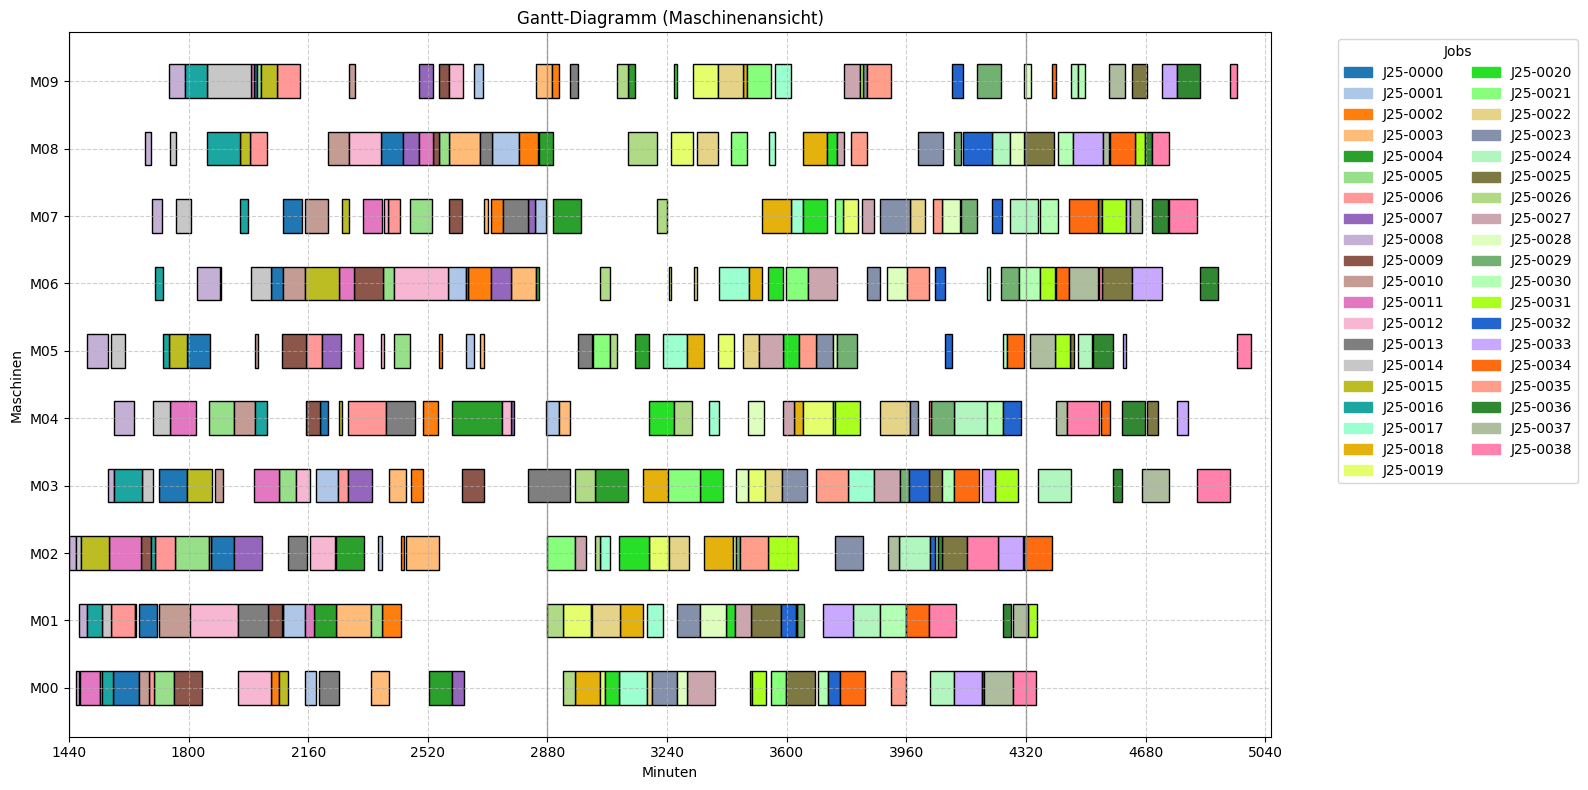

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [23]:
df_reschedule = df_schedule_simple

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### b) Neuplanung mit zusätzlich Minimierung der Planabweichung für die zuvor geplante Arbeitsgänge

In [24]:
df_schedule_devpen = lp_ft_reschedule.solve_jssp_with_devpen(df_jssp_current, df_jobs_arrivals_current, df_active,
                                                             df_original_plan = df_schedule, r = 0.60, # 60% Flowtime, 40% Abweichung
                                                             reschedule_start = day_start, solver= "HiGHS",
                                                             msg=False, timeLimit=max_time, gapRel= 0.02)
df_schedule_devpen

BigM: 15000

Solver-Informationen:
  Zielfunktionswert       : 33356.2
  Solver-Status           : Optimal
  Anzahl Variablen        : 2845
  Anzahl Constraints      : 5436
  Laufzeit                : ~900.19 Sekunden


,Job,Routing_ID,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,J25-0002,0,9,187,M09,2895.0,21.0,2729.0,2916.0
1,J25-0003,2,9,231,M04,2915.0,33.0,2717.0,2948.0
2,J25-0004,3,6,271,M07,2897.0,85.0,2711.0,2982.0
3,J25-0004,3,7,271,M03,3024.0,98.0,2851.0,3122.0
4,J25-0004,3,8,271,M09,3122.0,22.0,2873.0,3144.0
5,J25-0004,3,9,271,M05,3225.0,43.0,2997.0,3268.0
...,...,...,...,...,...,...,...,...,...
222,J25-0038,3,4,2815,M06,3523.0,9.0,717.0,3532.0
223,J25-0038,3,5,2815,M08,3532.0,52.0,769.0,3584.0
224,J25-0038,3,6,2815,M07,3584.0,85.0,854.0,3669.0


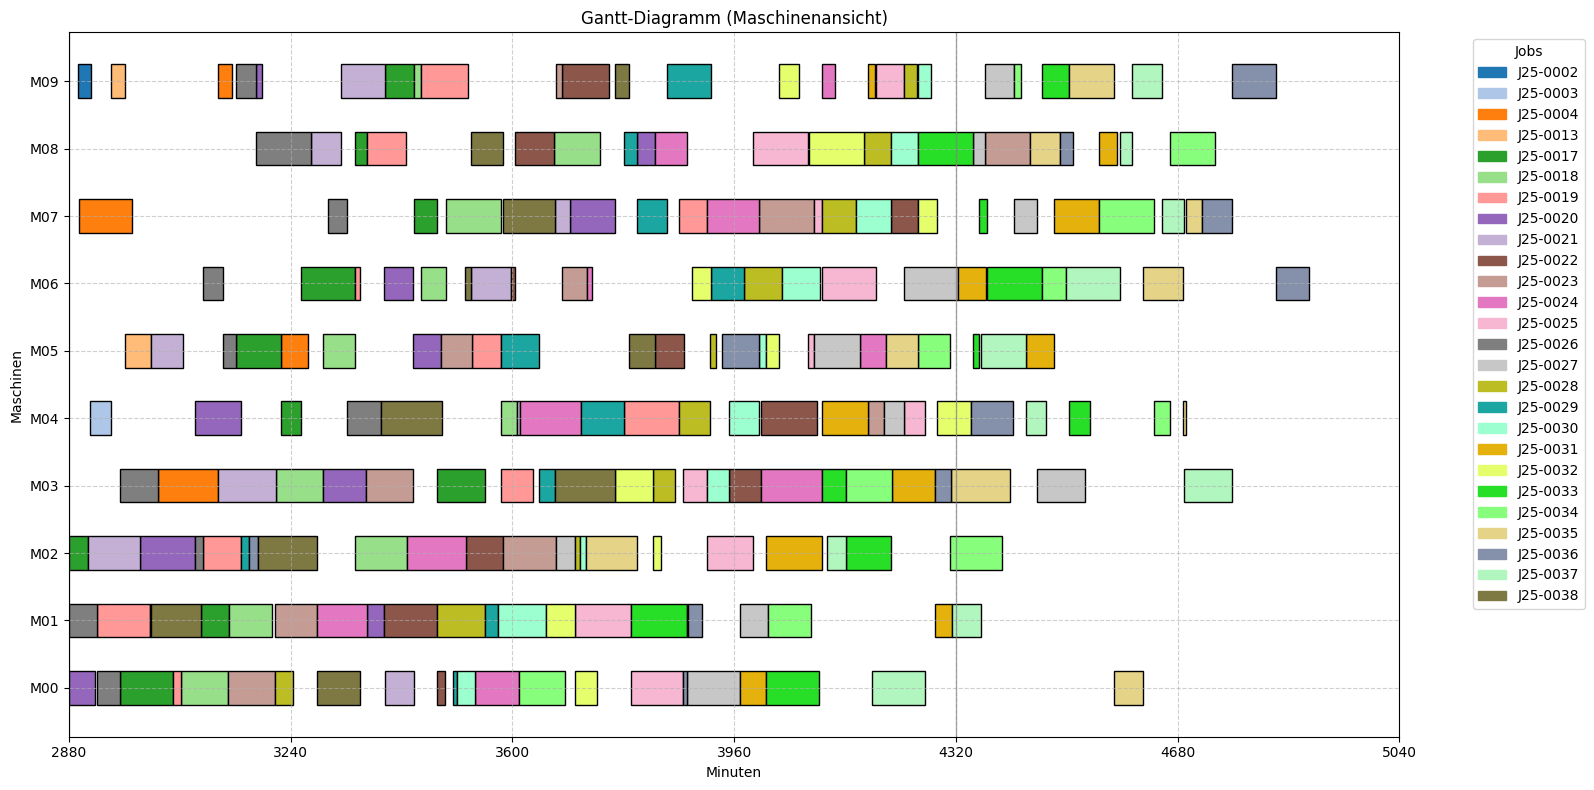

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [25]:
df_temp =  df_schedule_devpen

show.plot_gantt_machines(df_temp)
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

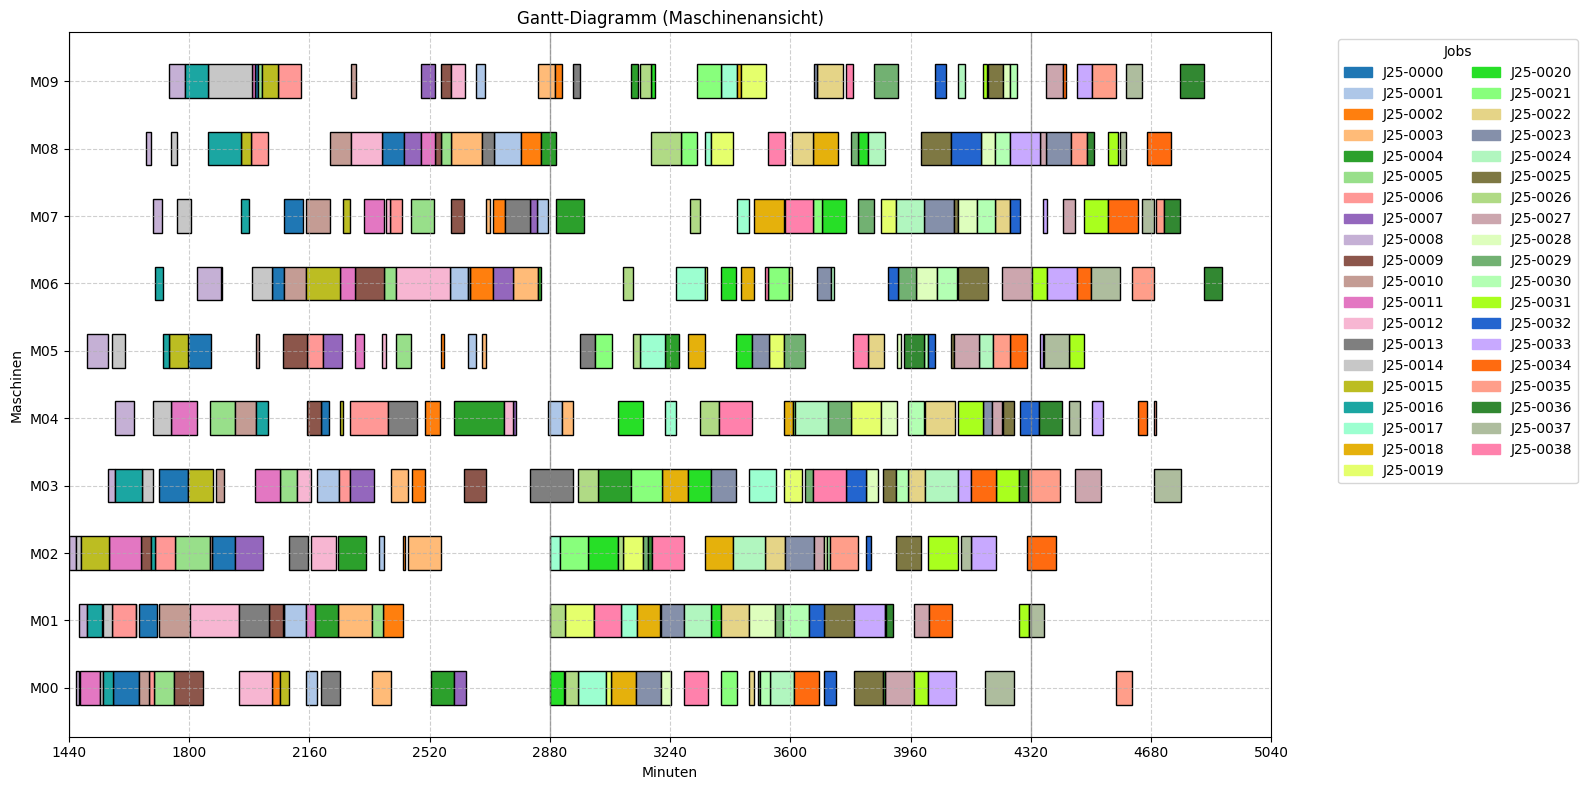

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [26]:
df_reschedule = df_schedule_devpen

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### Simulation

In [27]:
simulation.run(dframe_schedule_plan = df_schedule_devpen, start_time = day_start, end_time = day_end)

[Day 2 00:00:00] Job J25-0013, Operation 7 resumed with 69.00 min
[Day 2 00:00:00] Job J25-0003, Operation 8 resumed with 15.00 min
[Day 2 00:00:00] Job J25-0004, Operation 5 resumed with 17.00 min
[Day 2 00:00:00] Job J25-0001, Operation 9 resumed with 35.00 min
[Day 2 00:00:00] Job J25-0017 started on M02
[Day 2 00:00:00] Job J25-0020 started on M00
[Day 2 00:00:00] Job J25-0026 started on M01
[Day 2 00:15:00] Job J25-0003 finished on M09 (after 15 minutes)
[Day 2 00:15:00] Job J25-0002 started on M09
[Day 2 00:17:00] Job J25-0004 finished on M08 (after 17 minutes)
[Day 2 00:17:00] Job J25-0004 started on M07
[Day 2 00:31:00] Job J25-0002 finished on M09 (after 16 minutes)
[Day 2 00:35:00] Job J25-0001 finished on M04 (after 35 minutes)
[Day 2 00:35:00] Job J25-0003 started on M04
[Day 2 00:37:00] Job J25-0026 finished on M01 (after 37 minutes)
[Day 2 00:42:00] Job J25-0020 finished on M00 (after 42 minutes)
[Day 2 00:44:00] Job J25-0017 finished on M02 (after 44 minutes)
[Day 2 00:4

In [28]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

,Job,Routing_ID,Arrival,Operation,Machine,Start,Processing Time,End
0,J25-0001,6,123,9,M04,2875.0,40.0,2915.0
1,J25-0002,0,187,9,M09,2895.0,16.0,2911.0
2,J25-0003,2,231,8,M09,2845.0,50.0,2895.0
3,J25-0003,2,231,9,M04,2915.0,28.0,2943.0
4,J25-0004,3,271,5,M08,2855.0,42.0,2897.0
5,J25-0004,3,271,6,M07,2897.0,65.0,2962.0
...,...,...,...,...,...,...,...,...
164,J25-0038,3,2815,4,M06,3556.0,6.0,3562.0
165,J25-0038,3,2815,5,M08,3562.0,48.0,3610.0
166,J25-0038,3,2815,6,M07,3656.0,96.0,3752.0


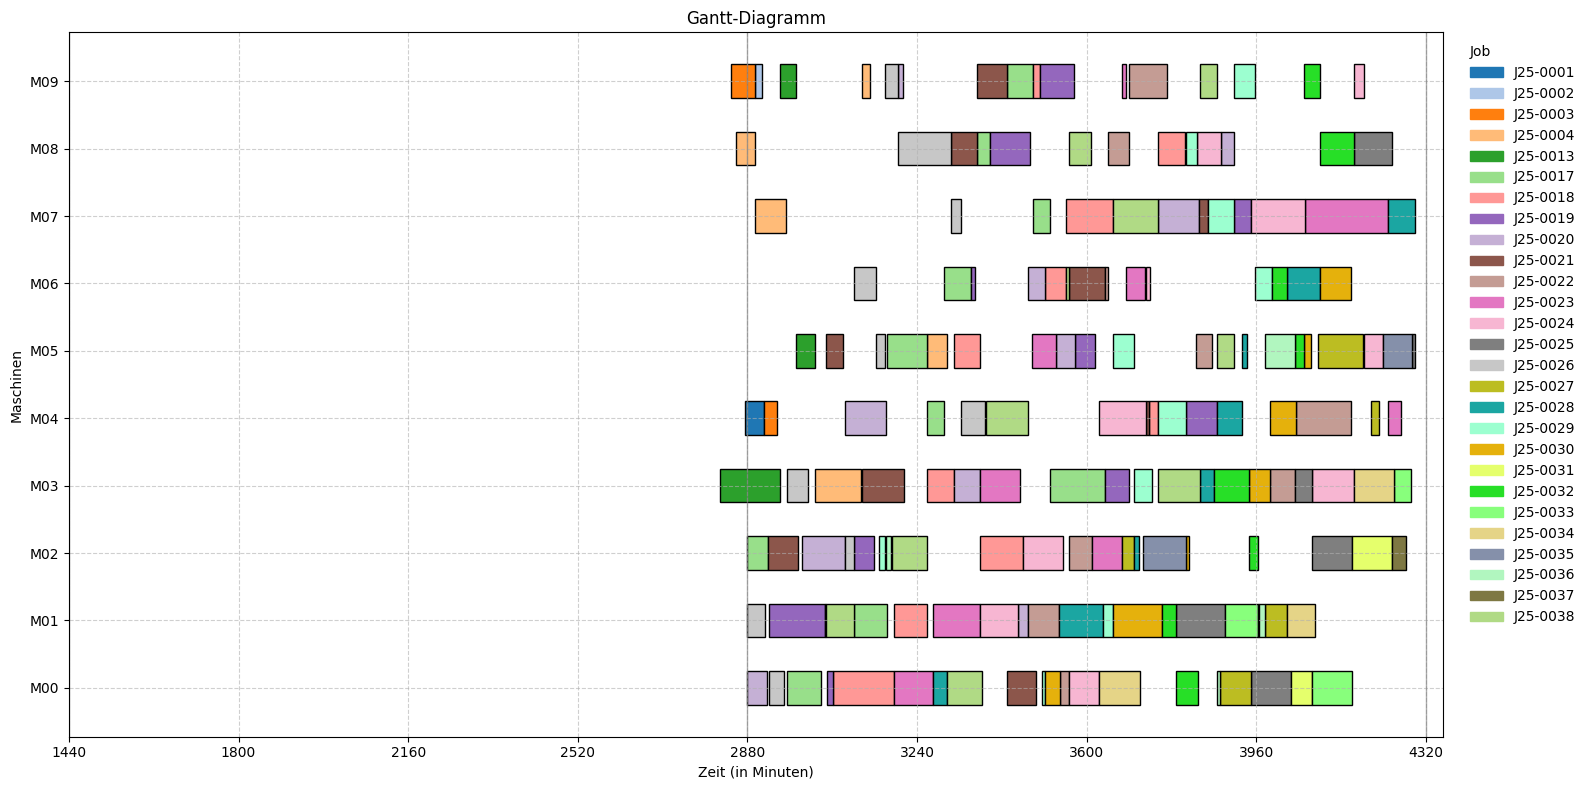

In [29]:
show.plot_gantt(df_execution2, perspective="Machine")

In [30]:
df_active2 = simulation.get_active_operations_df()
df_active2

,Routing_ID,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,7,J25-0027,5,M06,2157,4235.0,88.0,108.0,4323.0,4343.0
1,0,J25-0028,8,M08,2161,4297.0,44.0,56.0,4341.0,4353.0
2,0,J25-0030,7,M07,2191,4297.0,56.0,67.0,4353.0,4364.0
3,1,J25-0031,2,M04,2432,4267.0,75.0,64.0,4342.0,4331.0
4,2,J25-0033,3,M02,2520,4289.0,74.0,95.0,4363.0,4384.0
5,8,J25-0034,3,M05,2572,4296.0,51.0,45.0,4347.0,4341.0
6,4,J25-0036,4,M03,2590,4289.0,26.0,33.0,4315.0,4322.0
7,7,J25-0037,1,M00,2654,4277.0,86.0,93.0,4363.0,4370.0


In [31]:
df_not_started2 = simulation.get_not_started_operations_df(df_schedule)
df_not_started2

,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Start,End
0,J25-0000,8,0,M00,76,75,1440,1565.0,1641.0
1,J25-0000,8,1,M01,69,75,1440,1641.0,1710.0
2,J25-0000,8,2,M03,76,75,1440,1710.0,1786.0
3,J25-0000,8,3,M05,51,75,1440,1786.0,1837.0
4,J25-0000,8,4,M02,85,75,1440,1846.0,1931.0
5,J25-0000,8,5,M09,11,75,1440,1931.0,1942.0
...,...,...,...,...,...,...,...,...,...
152,J25-0016,6,4,M06,32,1421,1440,1655.0,1687.0
153,J25-0016,6,5,M05,21,1421,1440,1687.0,1708.0
154,J25-0016,6,6,M09,32,1421,1440,1708.0,1740.0


#### Check der Bedingungen des kombinierten Datensatzes aus den beiden Simulationsdaten

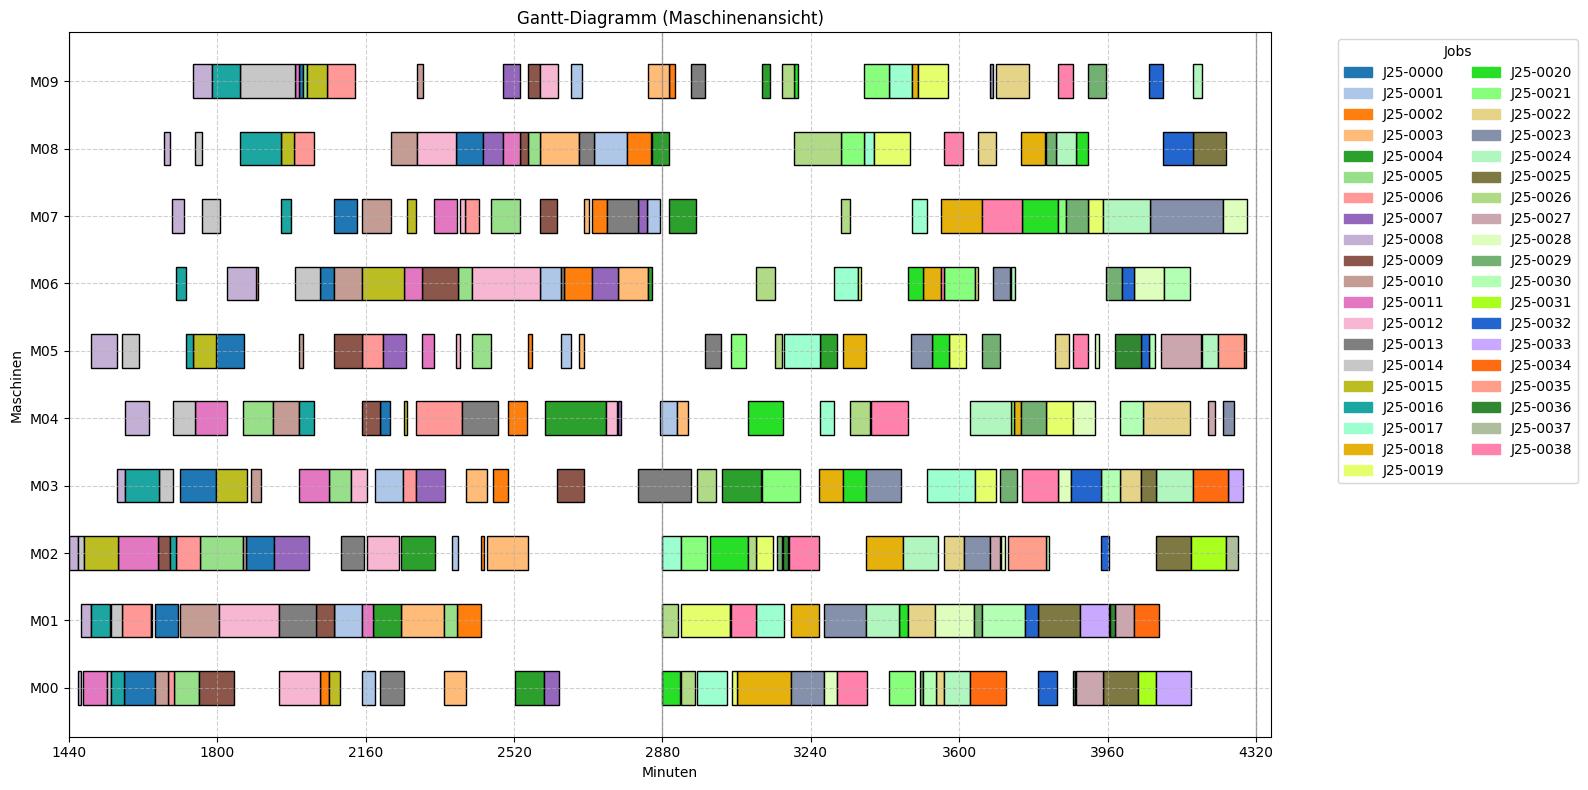

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [32]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)